# So sánh các mô hình 

In [65]:
import os 
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(),".."))
if project_root not in sys.path:
    sys.path.append(project_root)
import pandas as pd
from src.preprocessor_utils import split_data, trans_data
import joblib
from src.eval_metric import Metric
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score
)
from src.preprocessor_utils import get_dataCount,get_datatfidf,get_dataword2vec
import shap
from sklearn.utils import resample
import scipy.sparse


In [66]:
def plot_force_shap(model, X_train, X_test, index=0, sample_background=50):
    """
    Vẽ SHAP Force Plot.
    - Fix lỗi 'Truth value of an array is ambiguous'.
    - Xử lý triệt để định dạng Output của Sparse SHAP Values.
    """
    
    shap.initjs()
    model_type = type(model).__name__.lower()
    print(f"🔹 Đang tạo force plot cho index = {index}")
    print(f"🔹 Model loại: {model_type}")

    # --- 1. Lấy dữ liệu Sample (Input cho Model) ---
    if hasattr(X_test, "iloc"):
        sample_raw = X_test.iloc[index:index+1]
    else:
        sample_raw = X_test[index:index+1]

    # Input 2D cho model tính toán
    if hasattr(sample_raw, "toarray"):
        sample_input = sample_raw.toarray()
    else:
        sample_input = np.array(sample_raw)

    # Input 1D cho hàm vẽ (Hiển thị) -> Ép phẳng tuyệt đối
    sample_display = sample_input.flatten().astype(np.float32)

    try:
        # --- 2. Xử lý Model TREE ---
        if any(t in model_type for t in ["xgb", "forest", "tree", "gbm"]):
            print("→ Dùng TreeExplainer...")
            explainer = shap.TreeExplainer(model)
            
            # Tính SHAP
            shap_values = explainer.shap_values(sample_input)

            # --- A. XỬ LÝ BASE VALUE (SCALAR) ---
            base_value = explainer.expected_value
            # Nếu là list (RF), lấy class 1
            if isinstance(base_value, (list, np.ndarray)) and len(np.atleast_1d(base_value)) > 1:
                base_value = base_value[1]
            # Đảm bảo là số thực
            if isinstance(base_value, np.ndarray):
                base_value = base_value.item()

            # --- B. XỬ LÝ SHAP VALUES (1D ARRAY) ---
            # Random Forest trả về list [class0, class1]
            if isinstance(shap_values, list):
                raw_shap = shap_values[1] # Lấy mảng của class 1
            else:
                raw_shap = shap_values    # XGBoost binary

            # --- 🔥 FIX QUAN TRỌNG NHẤT Ở ĐÂY 🔥 ---
            # Nếu output của SHAP là Sparse Matrix, .toarray() để biến thành numpy thường
            if scipy.sparse.issparse(raw_shap):
                raw_shap = raw_shap.toarray()
            
            # Chuyển thành numpy array nếu chưa phải
            raw_shap = np.array(raw_shap)

            # Ép phẳng về 1 chiều (N_features,) thay vì (1, N_features)
            shap_val = raw_shap.flatten()

            # --- Debug kiểm tra kích thước trước khi vẽ ---
            print(f"   Debug Shape -> Base: {type(base_value)}, SHAP: {shap_val.shape}, Feat: {sample_display.shape}")

            return shap.force_plot(base_value, shap_val, sample_display)

        # --- 3. Xử lý Model NON-TREE ---
        else:
            print("→ Model Non-Tree...")
            # (Phần này code trước đã ổn, chỉ copy lại logic flatten)
            
            # Tạo background
            n_rows = X_train.shape[0] if hasattr(X_train, "shape") else len(X_train)
            n_bg = min(sample_background, n_rows)
            bg = X_train.sample(n_bg, random_state=42) if hasattr(X_train, "sample") else resample(X_train, n_samples=n_bg, random_state=42)
            if hasattr(bg, "toarray"): bg = bg.toarray()
            bg = np.array(bg, dtype=np.float32)

            # Explainer
            if "logistic" in model_type or "linear" in model_type:
                print("→ Dùng LinearExplainer")
                explainer = shap.LinearExplainer(model, bg)
            else:
                print("→ Dùng KernelExplainer")
                explainer = shap.KernelExplainer(model.predict_proba, bg)

            shap_values = explainer.shap_values(sample_input)

            # Base Value
            base_value = explainer.expected_value
            if isinstance(base_value, (list, np.ndarray)) and len(np.atleast_1d(base_value)) > 1:
                base_value = base_value[1]
            if isinstance(base_value, np.ndarray): base_value = base_value.item()

            # Shap Val
            if isinstance(shap_values, list): vals = shap_values[1]
            else: vals = shap_values
            
            # Flatten
            if scipy.sparse.issparse(vals): vals = vals.toarray()
            shap_val = np.array(vals).flatten()

            return shap.force_plot(base_value, shap_val, sample_display)

    except Exception as e:
        print(f"❌ Lỗi khi tạo force plot: {e}")
        import traceback
        traceback.print_exc()

In [67]:

def shapBeewarm(model,x_test):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    shap_values_obj = explainer(x_test)
    shap.summary_plot(shap_values, x_test)

In [68]:
print(project_root)

d:\PYTHON\data_mining\fraud-detection-post


In [69]:
path_test = os.path.join(project_root,"data","data_test.csv")
df = pd.read_csv(path_test)
x_test, y_test = split_data(df)

In [70]:
x_testc =  trans_data(x_test,"count")
x_testf = trans_data(x_test,"tfidf")
x_test2v = trans_data(x_test,"word2vec")

d:\PYTHON\data_mining\fraud-detection-post\src\feature_engineering.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['key_note'] = temp_text.str.contains(pattern, case=False, na=False).astype(int)
d:\PYTHON\data_mining\fraud-detection-post\src\feature_engineering.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['key_note'] = temp_text.str.contains(pattern, case=False, na=False).astype(int)
d:\PYTHON\data_mining\fraud-detection-post\src\feature_engineering.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['key_note'] = temp_text.str.contains(pattern, case=False, na=False).astype(int)
d:\anaconda\envs\tf_env\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call

In [85]:
model_lr1 = joblib.load(r"D:\PYTHON\data_mining\fraud-detection-post\models\model_lr_count.pkl")
model_lr2 = joblib.load(r"D:\PYTHON\data_mining\fraud-detection-post\models\models_lr.pkl")
model_xgb1 = joblib.load(r"D:\PYTHON\data_mining\fraud-detection-post\models\model_xgb_tf_tuneg.pkl")
model_xgb2 = joblib.load(r'D:\PYTHON\data_mining\fraud-detection-post\models\model_xgb_tunec_03.pkl')
model_nb = joblib.load(r"D:\PYTHON\data_mining\fraud-detection-post\models\model_nb_tunef_05.pkl")
model_rf1 = joblib.load(r"D:\PYTHON\data_mining\fraud-detection-post\models\rf_gcv_model_tuned_countdata.pkl") 
model_rf2 = joblib.load(r"D:\PYTHON\data_mining\fraud-detection-post\models\rf_gcv_model_tuned_tfidf.pkl")
model_rf3 = joblib.load(r"D:\PYTHON\data_mining\fraud-detection-post\models\rf_gcv_model_tuned_w2v.pkl")

In [87]:
x_trainc,y_trainc = get_dataCount()
x_trainf,y_trainf = get_datatfidf()
x_trainw2v,y_trainw2v = get_dataword2vec()

Mô hình logistic regression 

--- ĐÁNH GIÁ: LR (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.87      0.80      0.83       173

    accuracy                           0.98      3576
   macro avg       0.93      0.90      0.91      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC: 0.9840
PR-AUC (AUPRC): 0.8926 (Quan trọng cho Fraud)


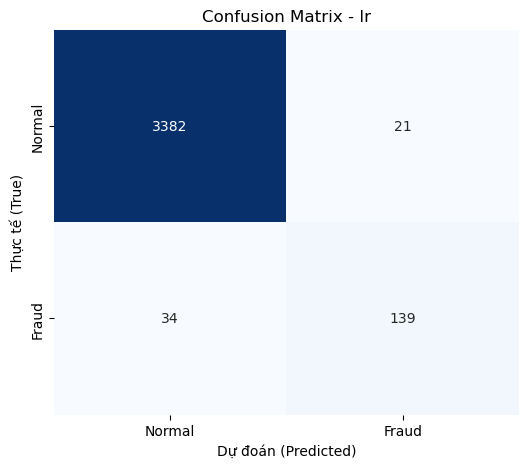

In [88]:
# countVec 
eval_lr1 = Metric(model_lr1,x_testc,y_test)
eval_lr1.evaluate_model("lr")


--- ĐÁNH GIÁ: LR (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3403
           1       0.67      0.90      0.77       173

    accuracy                           0.97      3576
   macro avg       0.83      0.94      0.88      3576
weighted avg       0.98      0.97      0.98      3576

ROC-AUC: 0.9900
PR-AUC (AUPRC): 0.9086 (Quan trọng cho Fraud)


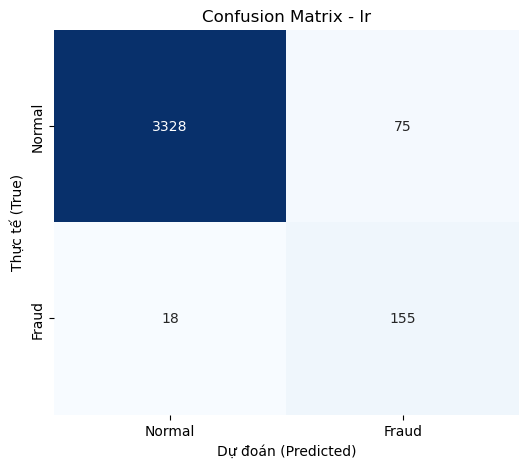

In [90]:
# tfidf 
eval_lr2 = Metric(model_lr2,x_testf,y_test)
eval_lr2.evaluate_model("lr")

Mô hình XGBoost

--- ĐÁNH GIÁ: XGB (Threshold=0.5) ---


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.95      0.71      0.81       173

    accuracy                           0.98      3576
   macro avg       0.97      0.85      0.90      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC: 0.9922
PR-AUC (AUPRC): 0.9263 (Quan trọng cho Fraud)


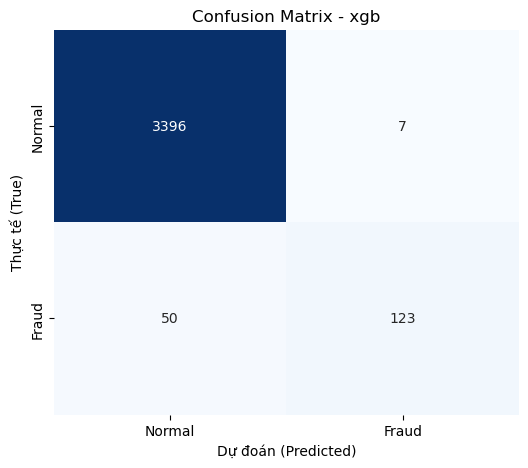

In [92]:
# tfidf 
eval_xgb1 = Metric(model_xgb1,x_testf,y_test)
eval_xgb1.evaluate_model("xgb")

--- ĐÁNH GIÁ: XGB (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.91      0.85      0.88       173

    accuracy                           0.99      3576
   macro avg       0.95      0.92      0.94      3576
weighted avg       0.99      0.99      0.99      3576

ROC-AUC: 0.9928
PR-AUC (AUPRC): 0.9446 (Quan trọng cho Fraud)


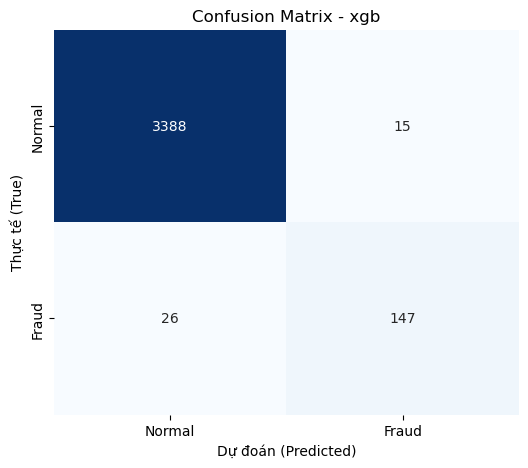

In [94]:
# count
eval_xgb2 = Metric(model_xgb2,x_testc,y_test)
eval_xgb2.evaluate_model("xgb")

Mô hình naive bayes 

--- ĐÁNH GIÁ: NB (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.92      0.57      0.70       173

    accuracy                           0.98      3576
   macro avg       0.95      0.78      0.84      3576
weighted avg       0.98      0.98      0.97      3576

ROC-AUC: 0.9774
PR-AUC (AUPRC): 0.8152 (Quan trọng cho Fraud)


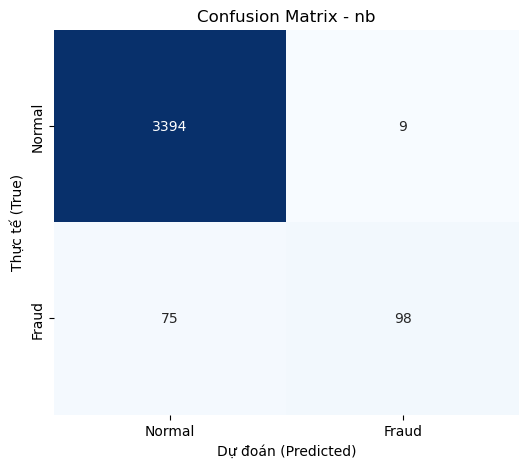

In [96]:
# tfidf 
eval_nb = Metric(model_nb,x_testf,y_test)
eval_nb.evaluate_model("nb")

Mô hình RandomForest

--- ĐÁNH GIÁ: RF (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.53      0.69       173

    accuracy                           0.98      3576
   macro avg       0.99      0.77      0.84      3576
weighted avg       0.98      0.98      0.97      3576

ROC-AUC: 0.9944
PR-AUC (AUPRC): 0.9522 (Quan trọng cho Fraud)


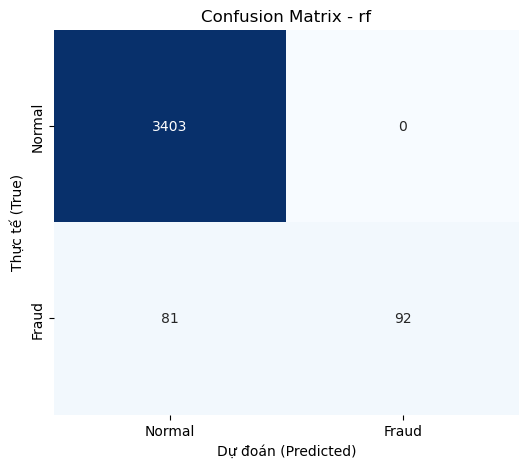

In [101]:
# countVec
eval_rf1 = Metric(model_rf1,x_testc,y_test)
eval_rf1.evaluate_model("rf")

--- ĐÁNH GIÁ: RF (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3403
           1       1.00      0.49      0.65       173

    accuracy                           0.98      3576
   macro avg       0.99      0.74      0.82      3576
weighted avg       0.98      0.98      0.97      3576

ROC-AUC: 0.9940
PR-AUC (AUPRC): 0.9424 (Quan trọng cho Fraud)


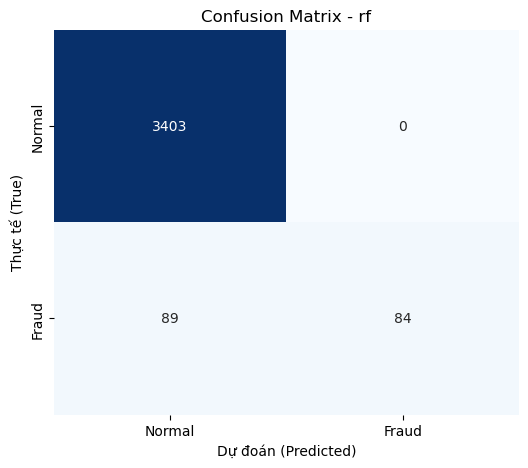

In [104]:
# TFIDF
eval_rf2 = Metric(model_rf2,x_testf,y_test)
eval_rf2.evaluate_model("rf")

--- ĐÁNH GIÁ: RF (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.90      0.70      0.79       173

    accuracy                           0.98      3576
   macro avg       0.94      0.85      0.89      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC: 0.9789
PR-AUC (AUPRC): 0.8619 (Quan trọng cho Fraud)


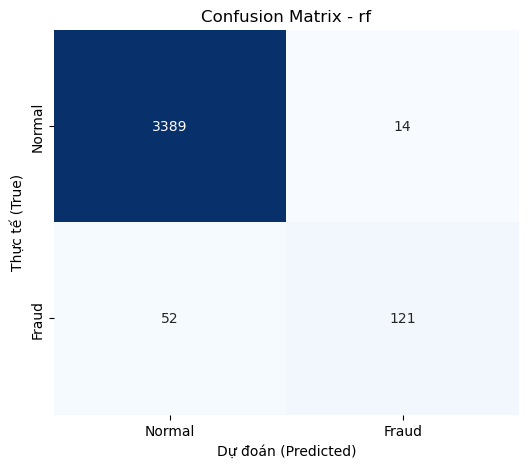

In [103]:
# word2vec
eval_rf3 = Metric(model_rf3,x_test2v,y_test)
eval_rf3.evaluate_model("rf")

Trả lời câu hỏi nghiên cứu 
1.  Thuật toán máy học nào cho hiệu suất cao nhất trong việc phân loại tin tuyển dụng. 

Thuật toán XGBoostclassifical

2. Làm thế nào để cân bằng giữa chỉ số precision và recall 

F1-Score là trung bình điều hòa (harmonic mean) giữa Precision (Độ chính xác) và Recall (Độ phủ/Độ nhạy). Nó được dùng khi bạn muốn tìm điểm cân bằng giữa hai chỉ số này.
$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

- Precision (P): Tỉ lệ số điểm thực sự đúng trong số những điểm mô hình dự đoán là đúng.
$$P = \frac{TP}{TP + FP}$$
- Recall (R): Tỉ lệ số điểm mô hình dự đoán đúng trong tổng số điểm thực tế là đúng.
$$R = \frac{TP}{TP + FN}$$

Không giống như F1-Score (được tính tại một ngưỡng threshold cụ thể), PR-AUC là diện tích nằm dưới đường cong Precision-Recall khi ta thay đổi ngưỡng phân loại (threshold) từ 0 đến 1.
$$\text{PR-AUC} = \int_{0}^{1} p(r) \, dr$$

3. Việc áp dụng các kỹ thuật tái lấy mẫu như smote thì liệu có ảnh hưởng như thế nào đến khả năng phát hiện tin giả của mô hình. 

